TO CREATE A COMPREHENSIVE PIPELINE FOR CREDIT CARD FRAUD DETECTION, WE MUST ENSURE THAT SOME KEY COMPONENTS ARE INCORPORATED:

HERE IS AN OBJECT ORIENTED STRUCTURE  TO MEET THESE REQUIREMENTS WITH PYTHON AND JUPYTER NOTEBOOK.

In [16]:
import warnings

import joblib
from joblib import dump, load
import json

import imblearn.under_sampling as us
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler

import ipywidgets as widgets
from IPython.display import display
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from collections import Counter

from keras.layers import Input
from keras.models import Model

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.layers import Conv1D, Dense, Flatten, LSTM, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")


In [17]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


DATA PROCESSING

In [18]:


class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def select_features(self, method):
        if method == 'correlation':
            # Selecting columns highly correlated with 'Class'
            correlation_scores = self.df.corr()['Class'].abs()
            top_correlated_columns = correlation_scores[(correlation_scores > 0.1) & (correlation_scores <= 1)].index
            # Exclude features with correlation between [-0.1, 0.1]

            # Include the specified columns
            included_columns = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']
            selected_columns = list(set(top_correlated_columns).intersection(included_columns))

            self.df = self.df[selected_columns]  # Update DataFrame with selected columns
            return self.df


        elif method == 'anova':
            X = self.df.drop(columns=['Class']).values
            y = self.df['Class'].values
            feature_scores, _ = f_classif(X, y)
            # Create a DataFrame with feature names and ANOVA scores
            feature_scores_df = pd.DataFrame({'Feature': self.df.drop(columns=['Class']).columns, 'ANOVA Score': feature_scores})
            # Sort the DataFrame by ANOVA scores in descending order
            feature_scores_df = feature_scores_df.sort_values(by='ANOVA Score', ascending=False)

            # Select features with ANOVA score greater than 50
            selected_features = feature_scores_df[feature_scores_df['ANOVA Score'] >= 50]['Feature'].tolist()

            self.df = self.df[selected_features + ['Class']]  # Update DataFrame with selected features
            return self.df
        else:
            raise ValueError("Invalid feature selection method. Please choose either 'correlation' or 'anova'.")


    def resample_data(self):
        # Get the counts of each class
        class_counts = self.df['Class'].astype(int).value_counts()

        # Identify the minority class (fraud) and majority class (non-fraud)
        minority_class_samples = class_counts.min()
        majority_class_samples = class_counts.max()

        # Calculate the desired number of samples for the majority class after undersampling
        desired_majority_samples = 10000

        # Calculate sampling strategy for undersampling
        undersampling_strategy = desired_majority_samples / majority_class_samples

        # Apply undersampling for the majority class
        under = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
        features = self.df.drop(columns=['Class']).values
        target = self.df['Class'].astype(int).values

        features_undersampled, target_undersampled = under.fit_resample(features, target)

        # Calculate desired minority class samples for oversampling
        desired_minority_samples = majority_class_samples * 0.5

        # Calculate the actual ratio of minority class samples to majority class samples after undersampling
        actual_minority_samples = len(target_undersampled[target_undersampled == 1])
        oversampling_strategy = min(desired_minority_samples / actual_minority_samples, 1.0)  # Limit to a maximum of 1

        # Apply oversampling for the minority class
        over = SMOTE(sampling_strategy=oversampling_strategy, random_state=42)
        features_resampled, target_resampled = over.fit_resample(features_undersampled, target_undersampled)

        # Combine resampled features and target variable into a DataFrame
        resampled_df = pd.DataFrame(features_resampled, columns=self.df.drop(columns=['Class']).columns)
        resampled_df['Class'] = target_resampled

        # Update the DataFrame with resampled data
        self.df = resampled_df

        # Print the final class counts using Counter
        print("Final Class Samples:")
        print(Counter(target_resampled))


    def handle_missing_values(self):
        # Impute missing values with mean for numerical features
        numerical_imputer = SimpleImputer(strategy="mean")
        self.df = pd.DataFrame(numerical_imputer.fit_transform(self.df), columns=self.df.columns)


    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)


    def handle_skewed_distributions(self):
        skewed_features = self.df.columns[self.df.skew() > 1] # Identify skewed features
        self.df[skewed_features] = self.df[skewed_features].apply(lambda x: np.log1p(x))
        # Handle missing values introduced by log transformation
        self.handle_missing_values()

    def split_data(self, test_size=0.2, random_state=42):
        X = self.df.drop(columns=['Class']).values
        y = self.df['Class'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

    def get_dataframe(self):
        return self.df


In [19]:

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

df = load_data('/content/drive/MyDrive/Flask/creditcard.csv')

In [20]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [21]:
# Instantiate DataPreprocessor with your DataFrame
preprocessor = DataPreprocessor(df)

preprocessor.select_features(method='correlation')
preprocessor.resample_data()
preprocessor.handle_missing_values()
preprocessor.remove_duplicates()

X_train, X_test, y_train, y_test = preprocessor.split_data(test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

print("Preprocessed DataFrame:")
print(preprocessor.get_dataframe().head())


Final Class Samples:
Counter({0: 13988, 1: 13988})
Training data shape: (22014, 9) (22014,)
Testing data shape: (5504, 9) (5504,)
Preprocessed DataFrame:
        V14        V7       V16        V4       V17       V11        V3  \
0 -1.054631  0.388881  0.601226  0.716564  0.631117 -0.325347 -0.666593   
1  0.573006  0.495236 -0.011633  0.694584 -0.504570  0.821998  0.904547   
2 -0.338340 -0.701304 -0.756390 -1.308725  0.535141  0.575866  1.122074   
3 -0.436671  0.775644  0.266437 -0.029567  0.703234 -0.841133 -0.987421   
4  1.323225 -0.721945  1.317655  3.866438 -0.441076  1.297531  0.269272   

        V12       V10  Class  
0 -0.216435 -0.597739    0.0  
1  0.468322  0.170547    0.0  
2 -0.594037  2.051312    0.0  
3 -0.586472 -1.238598    0.0  
4 -1.920966  1.166335    0.0  


VISUALIZATION

In [22]:


class Visualizer:
    @staticmethod
    def piechart(df):
        # Calculate fraud and no-fraud percentages
        fraud_count = len(df[df['Class'] == 1])
        nofraud_count = len(df[df['Class'] == 0])
        total_count = fraud_count + nofraud_count

        if total_count == 0:
            raise ValueError("No data available to plot.")

        fraud_percentage = fraud_count / total_count * 100
        nofraud_percentage = nofraud_count / total_count * 100

        # Create pie chart for fraud vs no-fraud percentage
        percentages = [nofraud_percentage, fraud_percentage]
        labels = ['No Fraud', 'Fraud']
        colors = ['#1f77b4', '#ff7f0e']
        plt.figure(figsize=(10, 5))
        plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90,
                colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
        plt.title('Fraud vs No Fraud Percentage')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.show()

    def plot_mean_heatmap(data):
        fraud = data[data['Class'] == 1].describe().T
        nofraud = data[data['Class'] == 0].describe().T

        colors = ['#FFD700','#3B3B3C']

        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

        plt.subplot(2, 2, 1)
        sns.heatmap(fraud[['mean']][:15], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
        plt.title('Fraud Samples: Part 1')

        plt.subplot(2, 2, 2)
        sns.heatmap(fraud[['mean']][15:30], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
        plt.title('Fraud Samples: Part 2')

        plt.subplot(2, 2, 3)
        sns.heatmap(nofraud[['mean']][:15], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
        plt.title('No Fraud Samples: Part 1')

        plt.subplot(2, 2, 4)
        sns.heatmap(nofraud[['mean']][15:30], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
        plt.title('No Fraud Samples: Part 2')

        fig.tight_layout(w_pad=2)
        plt.show()

    @staticmethod
    def barchart(df):
        sns.countplot(x='Class', data=df, hue='Class', palette=['#1f77b4', '#ff7f0e'])
        plt.title('Class Distribution')
        plt.yscale('log')
        plt.ylabel('Count (log scale)')
        plt.xlabel('Class')
        plt.show()


    @staticmethod
    def plot_heatmap(df):
        sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
        plt.show()

    @staticmethod
    def correlation_heatmaps(df, colors=None):
        # Fill NaN values with mean
        df = df.fillna(df.mean())

        corr = df.corrwith(df['Class']).sort_values(ascending=False).to_frame()
        corr.columns = ['Correlation']
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 10))

        plt.subplot(1, 2, 1)
        sns.heatmap(corr.iloc[:15, :], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
        plt.title('Part 1')

        plt.subplot(1, 2, 2)
        sns.heatmap(corr.iloc[15:30], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False)
        plt.title('Part 2')

        fig.tight_layout(w_pad=2)
        plt.show()


    @staticmethod
    def anova_scores_heatmaps(df, colors=None):
        # Data preprocessing steps
        preprocessor = DataPreprocessor(df)
        feature_scores = preprocessor.select_features('anova')

        # Check if feature_scores is empty
        if feature_scores.empty:
            raise ValueError("No features selected by ANOVA.")

        # Filter out non-numeric columns
        numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

        # Create a boolean array for indexing
        feature_mask = df.columns.isin(feature_scores) & df.columns.isin(numerical_columns)

        if not any(feature_mask):
            raise ValueError("No numerical features selected by ANOVA.")

        # Apply boolean indexing to obtain ANOVA scores DataFrame
        anova_scores_df = df.loc[:, feature_mask]

        # Calculate ANOVA scores
        anova_scores = pd.DataFrame(index=anova_scores_df.columns, columns=["ANOVA Score"])
        for col in anova_scores_df.columns:
            anova_scores.loc[col, "ANOVA Score"] = ss.f_oneway(
                anova_scores_df[col][df['Class'] == 0],
                anova_scores_df[col][df['Class'] == 1]
            )[0]

        # Sort ANOVA scores
        sorted_anova_scores = anova_scores.sort_values(by='ANOVA Score', ascending=False)
        # Convert ANOVA scores to float
        sorted_anova_scores['ANOVA Score'] = sorted_anova_scores['ANOVA Score'].astype(float)

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(sorted_anova_scores.values.reshape(1, -1), cmap='Blues', aspect='auto')
        plt.colorbar()
        plt.xticks(ticks=range(len(sorted_anova_scores)), labels=sorted_anova_scores.index, rotation=90)
        plt.title('ANOVA Scores Heatmap')
        plt.xlabel('Features')
        plt.ylabel('ANOVA Score')
        plt.show()


def plot_visuals(choice):
    if choice == 'Pie Chart':
        Visualizer.piechart(df)
    elif choice == 'Bar Chart':
        Visualizer.barchart(df)
    elif choice == 'Heatmap':
        Visualizer.plot_heatmap(df)
    elif choice == 'Correlation Heatmaps':
        Visualizer.correlation_heatmaps(df)
    elif choice == 'ANOVA Scores Heatmaps':
        Visualizer.anova_scores_heatmaps(df)
    elif choice == 'Mean Heatmap':
        Visualizer.plot_mean_heatmap(df)


# Creating a dropdown widget for selecting the visualization type
visualization_dropdown = widgets.Dropdown(options=['Pie Chart', 'Bar Chart', 'Heatmap', 'Correlation Heatmaps', 'ANOVA Scores Heatmaps', 'Mean Distribution Heatmap'],
                                          description='Visualization Type:')

# Calling the plot_visuals function whenever the dropdown value changes
widgets.interactive(plot_visuals, choice=visualization_dropdown)


interactive(children=(Dropdown(description='Visualization Type:', options=('Pie Chart', 'Bar Chart', 'Heatmap'…

MODELING

In [23]:
# Base class for model trainers
class ModelTrainerBase:
    def train_model(self, X_train, y_train):
        raise NotImplementedError("train_model method not implemented")

# Trainer for LSTM models
class LSTMTrainer(ModelTrainerBase):
    def train_model(self, X_train, y_train):
        input_shape = (X_train.shape[1], 1)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape input data for LSTM

        inputs = Input(shape=input_shape)
        lstm_out = LSTM(60, activation='relu')(inputs)
        outputs = Dense(1, activation='sigmoid')(lstm_out)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, validation_split=0.2)
        return model


# Trainer for CNN models
class CNNTrainer(ModelTrainerBase):
    def train_model(self, X_train, y_train):
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape input data for CNN
        input_shape = (X_train.shape[1], 1)

        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, validation_split=0.2)
        return model


# Model trainer class
class ModelTrainer:
    def __init__(self):
        self.model_trainers = {
            "LSTM": LSTMTrainer(),
            "CNN": CNNTrainer(),
            "RandomForest": self.train_random_forest,
            "DecisionTree": self.train_decision_tree,
            "GradientBoosting": self.train_gradient_boosting,
            "SVM": self.train_svm,
            "KNN": self.train_knn,
            "NaiveBayes": self.train_naive_bayes,
            "LogisticRegression": self.train_logistic_regression
            # Add other model trainers here...
        }

    def train_model(self, model_type, X_train, y_train, verbose=True):
        if model_type in self.model_trainers:
            if isinstance(self.model_trainers[model_type], ModelTrainerBase):
                return self.model_trainers[model_type].train_model(X_train, y_train)
            else:
                return self.model_trainers[model_type](X_train, y_train)  # Train non-class-based models
        else:
            raise ValueError(f"Unknown model type: {model_type}")

    @staticmethod
    def train_random_forest(X_train, y_train):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_decision_tree(X_train, y_train):
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_gradient_boosting(X_train, y_train):
        model = GradientBoostingClassifier()
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_svm(X_train, y_train):
        model = SVC(probability=True, class_weight='balanced')
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_knn(X_train, y_train):
        model = KNeighborsClassifier()
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_naive_bayes(X_train, y_train):
        model = GaussianNB()
        model.fit(X_train, y_train)
        return model

    @staticmethod
    def train_logistic_regression(X_train, y_train):
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        return model

# Model evaluator class
class ModelEvaluator:
    @staticmethod
    def evaluate_model(model, X_test, y_test):
        if len(X_test.shape) == 2:
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Remove .values
        # Reshape X_test if it has 3 dimensions
        if len(X_test.shape) == 3:
            num_samples, num_timesteps, num_features = X_test.shape
            X_test = X_test.reshape((num_samples, num_timesteps * num_features))

        y_pred_proba = model.predict(X_test)

        # Check if y_test is multiclass and convert it to binary if necessary
        if len(np.unique(y_test)) > 2:
            y_pred = np.argmax(y_pred_proba, axis=1)
            y_test_single_column = np.argmax(y_test, axis=1)
        else:
            y_pred = (y_pred_proba > 0.5).astype(int)
            y_test_single_column = y_test

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test_single_column, y_pred)
        precision = precision_score(y_test_single_column, y_pred, average='binary')  # For binary classification
        recall = recall_score(y_test_single_column, y_pred, average='binary')  # For binary classification
        f1 = f1_score(y_test_single_column, y_pred, average='binary')  # For binary classification

        evaluation_metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }

        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(classification_report(y_test_single_column, y_pred))

        auc = roc_auc_score(y_test_single_column, y_pred_proba)
        print(f'ROC AUC Score: {auc:.2f}')

        cm = confusion_matrix(y_test_single_column, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return evaluation_metrics

    @staticmethod
    def save_model(model, file_path):
        model.save(file_path)



Training and evaluating LSTM...
Epoch 1/10
551/551 [==============================] - 7s 8ms/step - loss: 0.2201 - accuracy: 0.9156 - val_loss: 0.1655 - val_accuracy: 0.9330
Epoch 2/10
551/551 [==============================] - 5s 9ms/step - loss: 0.1599 - accuracy: 0.9348 - val_loss: 0.1591 - val_accuracy: 0.9335
Epoch 3/10
551/551 [==============================] - 6s 11ms/step - loss: 0.1507 - accuracy: 0.9353 - val_loss: 0.1560 - val_accuracy: 0.9375
Epoch 4/10
551/551 [==============================] - 5s 9ms/step - loss: 0.1470 - accuracy: 0.9365 - val_loss: 0.1570 - val_accuracy: 0.9391
Epoch 5/10
551/551 [==============================] - 5s 9ms/step - loss: 0.1419 - accuracy: 0.9389 - val_loss: 0.1579 - val_accuracy: 0.9432
Epoch 6/10
551/551 [==============================] - 5s 9ms/step - loss: 0.1349 - accuracy: 0.9430 - val_loss: 0.1528 - val_accuracy: 0.9457
Epoch 7/10
551/551 [==============================] - 4s 7ms/step - loss: 0.1286 - accuracy: 0.9447 - val_loss: 0.1

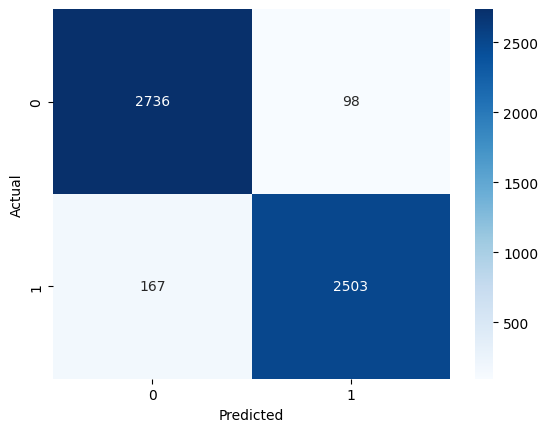

Training and evaluating CNN...
Epoch 1/10
551/551 [==============================] - 3s 3ms/step - loss: 0.1720 - accuracy: 0.9344 - val_loss: 0.1427 - val_accuracy: 0.9459
Epoch 2/10
551/551 [==============================] - 1s 3ms/step - loss: 0.1350 - accuracy: 0.9448 - val_loss: 0.1282 - val_accuracy: 0.9484
Epoch 3/10
551/551 [==============================] - 1s 2ms/step - loss: 0.1222 - accuracy: 0.9499 - val_loss: 0.1196 - val_accuracy: 0.9587
Epoch 4/10
551/551 [==============================] - 1s 3ms/step - loss: 0.1103 - accuracy: 0.9568 - val_loss: 0.1187 - val_accuracy: 0.9584
Epoch 5/10
551/551 [==============================] - 1s 3ms/step - loss: 0.1026 - accuracy: 0.9616 - val_loss: 0.1060 - val_accuracy: 0.9628
Epoch 6/10
551/551 [==============================] - 2s 4ms/step - loss: 0.0934 - accuracy: 0.9652 - val_loss: 0.1029 - val_accuracy: 0.9650
Epoch 7/10
551/551 [==============================] - 2s 4ms/step - loss: 0.0880 - accuracy: 0.9668 - val_loss: 0.096

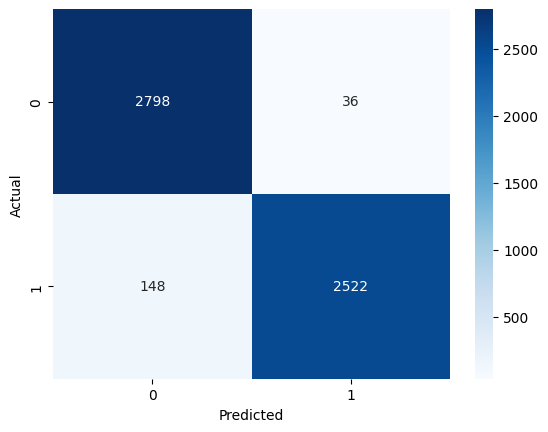

Training and evaluating RandomForest...
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2834
         1.0       0.99      0.99      0.99      2670

    accuracy                           0.99      5504
   macro avg       0.99      0.99      0.99      5504
weighted avg       0.99      0.99      0.99      5504

ROC AUC Score: 0.99


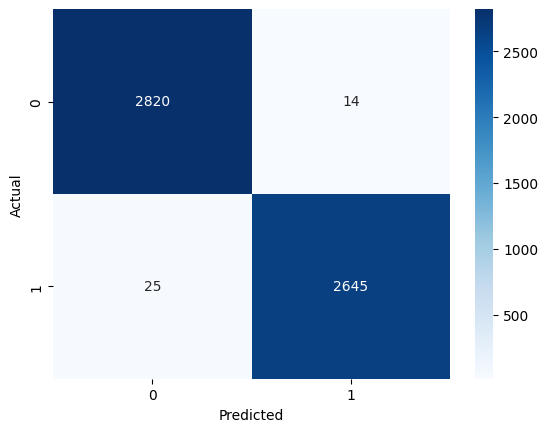

Training and evaluating DecisionTree...
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2834
         1.0       0.98      0.98      0.98      2670

    accuracy                           0.98      5504
   macro avg       0.98      0.98      0.98      5504
weighted avg       0.98      0.98      0.98      5504

ROC AUC Score: 0.98


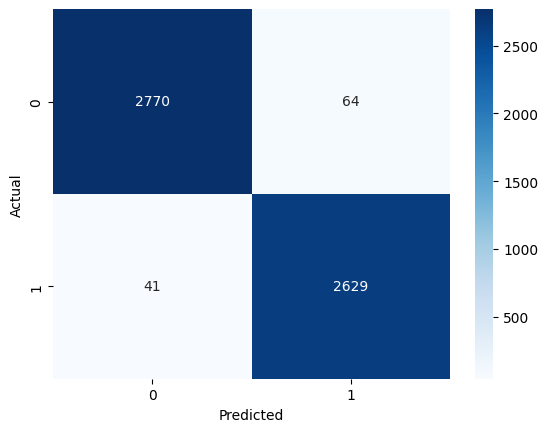

Training and evaluating GradientBoosting...
Accuracy: 0.97
Precision: 0.98
Recall: 0.95
F1 Score: 0.96
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2834
         1.0       0.98      0.95      0.96      2670

    accuracy                           0.97      5504
   macro avg       0.97      0.96      0.97      5504
weighted avg       0.97      0.97      0.97      5504

ROC AUC Score: 0.96


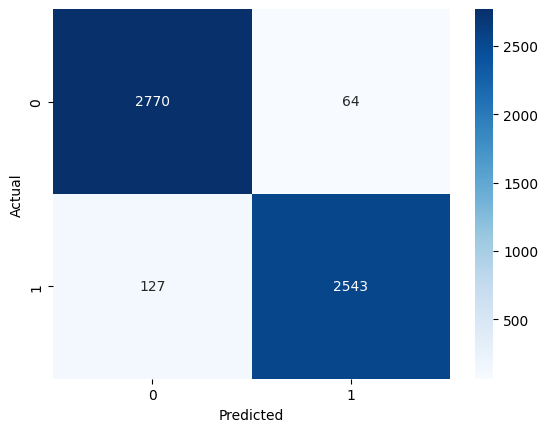

Training and evaluating SVM...
Accuracy: 0.94
Precision: 0.99
Recall: 0.89
F1 Score: 0.93
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2834
         1.0       0.99      0.89      0.93      2670

    accuracy                           0.94      5504
   macro avg       0.94      0.94      0.94      5504
weighted avg       0.94      0.94      0.94      5504

ROC AUC Score: 0.94


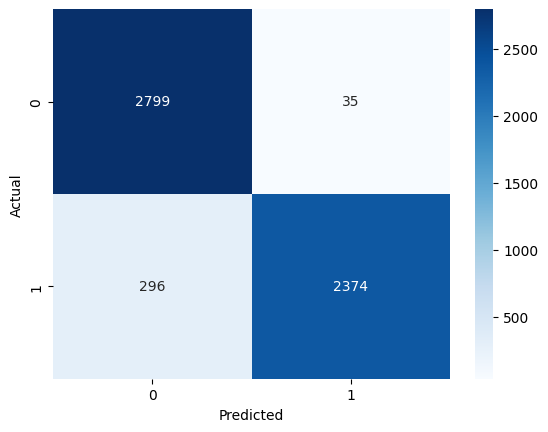

Training and evaluating KNN...
Accuracy: 0.99
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2834
         1.0       0.97      1.00      0.99      2670

    accuracy                           0.99      5504
   macro avg       0.99      0.99      0.99      5504
weighted avg       0.99      0.99      0.99      5504

ROC AUC Score: 0.99


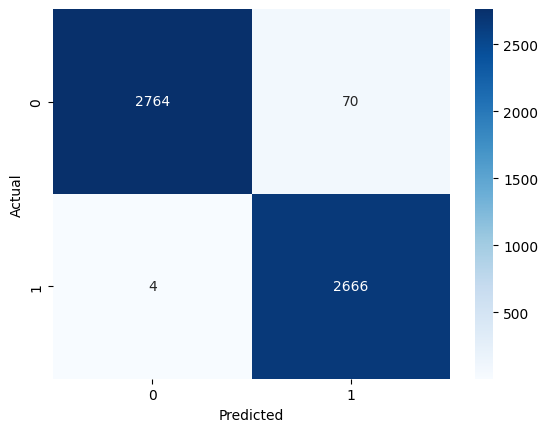

Training and evaluating NaiveBayes...
Accuracy: 0.92
Precision: 0.98
Recall: 0.85
F1 Score: 0.91
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      2834
         1.0       0.98      0.85      0.91      2670

    accuracy                           0.92      5504
   macro avg       0.93      0.92      0.92      5504
weighted avg       0.92      0.92      0.92      5504

ROC AUC Score: 0.92


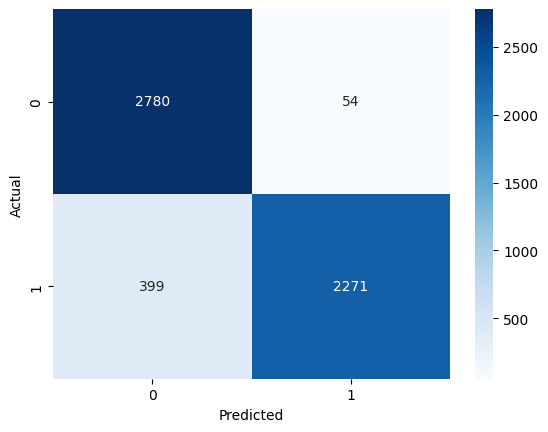

Training and evaluating LogisticRegression...
Accuracy: 0.94
Precision: 0.97
Recall: 0.90
F1 Score: 0.93
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2834
         1.0       0.97      0.90      0.93      2670

    accuracy                           0.94      5504
   macro avg       0.94      0.94      0.94      5504
weighted avg       0.94      0.94      0.94      5504

ROC AUC Score: 0.94


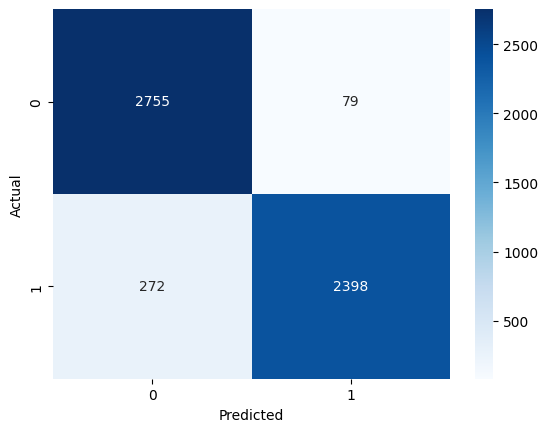

Evaluation Results:
                    Accuracy  Precision    Recall  F1-score
LSTM                0.951853   0.962322  0.937453  0.949725
CNN                 0.966570   0.985927  0.944569  0.964805
RandomForest        0.992914   0.994735  0.990637  0.992682
DecisionTree        0.980923   0.976235  0.984644  0.980421
GradientBoosting    0.965298   0.975451  0.952434  0.963805
SVM                 0.939862   0.985471  0.889139  0.934830
KNN                 0.986555   0.974415  0.998502  0.986312
NaiveBayes          0.917696   0.976774  0.850562  0.909309
LogisticRegression  0.936228   0.968107  0.898127  0.931805


In [24]:
trainer = ModelTrainer()
evaluator = ModelEvaluator()

# Dictionary to store evaluation results
results = {}

# Train and evaluate each model
for model_type in trainer.model_trainers.keys():
    print(f"Training and evaluating {model_type}...")
    model = trainer.train_model(model_type, X_train, y_train)
    results[model_type] = evaluator.evaluate_model(model, X_test, y_test)

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results).T

print("Evaluation Results:")
print(results_df)

# Save the results to a CSV file
results_df.to_csv("model_evaluation_results.csv")


HYPERPARAMETER TUNING

In [25]:

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_model = RandomForestClassifier(random_state=42)

# # Perform grid search for hyperparameter tuning
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Train Random Forest model with best hyperparameters
# best_rf_model = RandomForestClassifier(random_state=42, **best_params)
# best_rf_model.fit(X_train, y_train)

# evaluator = ModelEvaluator()
# best_rf_evaluation = evaluator.evaluate_model(best_rf_model, X_test, y_test)

# with open("best_random_forest_params.json", "w") as f:
#     json.dump(best_params, f)

# # Save the best Random Forest model
# dump(best_rf_model, "best_random_forest_model.pkl")

# print("Evaluation Results for Random Forest with Best Hyperparameters:")
# print(best_rf_evaluation)

In [28]:
# preprocessor = DataPreprocessor(df)


# preprocessor.select_features(method='anova')
# preprocessor.resample_data()
# preprocessor.handle_missing_values()
# preprocessor.remove_duplicates()
# preprocessor.split_data()

# df_anova = preprocessor.get_dataframe()

# # Assuming the preprocessed data has been split into X_train, X_test, y_train, y_test
# print("Training data shape:", X_train.shape, y_train.shape)
# print("Testing data shape:", X_test.shape, y_test.shape)

# try:
#     # Load the best Random Forest model
#     best_rf_model = load("/content/drive/MyDrive/Flask/best_random_forest_model.pkl")
# except ValueError as e:
#     print("Loading model failed due to version mismatch. Re-training the model.")
#     # Load the best parameters from the JSON file
#     with open("/content/drive/MyDrive/Flask/best_random_forest_params.json", "r") as f:
#         best_params = json.load(f)

#     # Retrain the Random Forest model with the best parameters
#     best_rf_model = RandomForestClassifier(random_state=42, **best_params)
#     best_rf_model.fit(X_train, y_train)

#     # Save the retrained model
#     dump(best_rf_model, "/content/drive/MyDrive/Flask/best_random_forest_model.pkl")
#     print("Retrained Random Forest model saved as 'best_random_forest_model.pkl'")

# # Make predictions using the loaded/retrained model
# predictions = best_rf_model.predict(X_test)

# # Evaluate the model using ModelEvaluator
# evaluator = ModelEvaluator()
# evaluator.evaluate_model(best_rf_model, X_test, y_test)


### References :
- https://www.chargebackgurus.com/blog/credit-card-fraud-detection
- https://www.cnbc.com/select/what-is-a-credit-card/
- https://www.bajajfinserv.in/credit-card-fraud-in-india
- https://www.fortunebusinessinsights.com/industry-reports/fraud-detection-and-prevention-market-100231
- https://www.kaggle.com/tanmay111999/code
